# Classify architecture type from an image of a home

Idea with this project is to classify architecture type from an image of a home

- maybe look at geographic trends in home type?
- not sure exactly.

Here are the types we're are using for classification:
1. prairie-style (prairie)
2. Queen Anne victorian (victorian)
3. Chicago bungalow (bungalow)
4. American foursquare (foursquare)


In [1]:
# Need to run `PYTORCH_ENABLE_MPS_FALLBACK=1 jupyter notebook` before loading this notebook
# there is an error that pops up later with augmentation that I couldn't figure out how to change while in the notebook.

# Suppress warnings from PyTorch
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

# fastai V1 library which sits on top of Pytorch 1.0
from fastai.vision import *

import requests

from bs4 import BeautifulSoup

from fastai.vision.all import *
from fastai.vision import *

# import my custom functions
from src.utils import _label_func

import pandas as pd
import matplotlib.pyplot as plt



## Look at results

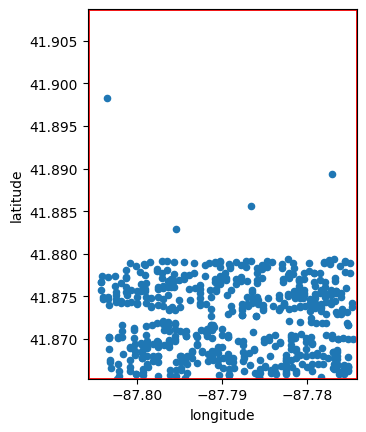

In [2]:
# now I need to find out how to extract data...
# soup.contents

# ok- thinking about this
# according to xx there are 25000 homes in Oak Park
# on redfin, there are ~3000 in last 5 years

# TODO make sure my scraping script is outputting home metadata correctly

# load redfin metadata
rf_metadata = pd.read_csv('data/interim/redfin_metadata.csv')

# Fill NaN values with a placeholder integer (e.g., -1)
rf_metadata['property_id'] = rf_metadata['property_id'].fillna(-1).astype(int)

# Google maps coordinates of bounding box for Oak Park
uleft = 41.90872286303018, -87.80575098756486
lright = 41.86533629647352, -87.7741652965275

# Filter out homes that are not in Oak Park (based on google maps coordinates)
rf_metadata['in_oak_park'] = [1 if x['latitude'] < uleft[0] and x['latitude'] > lright[0] and x['longitude'] < lright[1] and x['longitude'] > uleft[1] else 0 for x in rf_metadata.to_dict(orient='records')]
rf_metadata = rf_metadata[rf_metadata['in_oak_park'] == 1]

# Plot the latitude and longitude of the homes
rf_metadata.plot(kind='scatter', x='longitude', y='latitude')

# Draw rectangle for Oak Park
plt.gca().add_patch(plt.Rectangle((uleft[1], lright[0]), lright[1] - uleft[1], uleft[0] - lright[0], 
                                  edgecolor='r', facecolor='none', lw=2))

plt.xlim(min(rf_metadata['longitude'].min(), uleft[1]), max(rf_metadata['longitude'].max(), lright[1]))
plt.ylim(min(rf_metadata['latitude'].min(), lright[0]), max(rf_metadata['latitude'].max(), uleft[0]))

plt.gca().set_aspect('equal', adjustable='box')

## House image classifier

### Image loading setup

In [3]:
# get images for training the model
path = "/Users/chad/github/architecture/images/training"
fnames = get_image_files(path)

len(fnames) # 65 images


65

### Use image augmentation to increase training samples

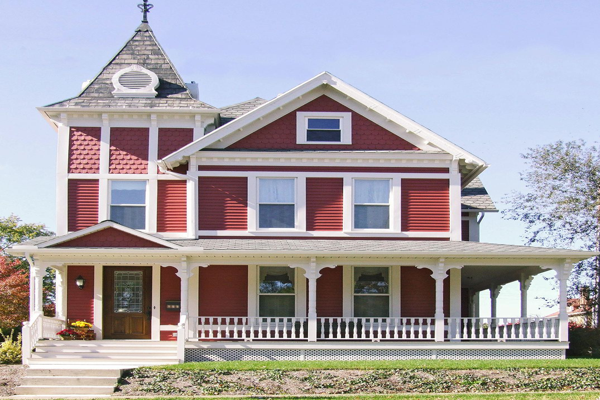

In [4]:
# single image of a house
img = PILImage(PILImage.create(fnames[0]).resize((600,400)))
img

In [5]:
# tensor.. ?
timg = TensorImage(array(img)).permute(2,0,1).float()/255.

In [6]:
# setup augmentation transforms of image
tfms = aug_transforms(pad_mode='zeros', mult=2, min_scale=0.75, do_flip=True, flip_vert=False, max_rotate=3, max_zoom=1.1,
                     max_lighting=0.2, max_warp=0.1, p_affine=0.75, p_lighting=0.5)

# NB: I took these parameters from an existing project on github-
# https://github.com/dumitrux/architectural-style-recognition/blob/master/src/architectural-style-recognition.ipynb
# tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=10, max_zoom=1.1, 
#                       max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)
# NB: this get_transforms function is for the old fastai/pytorch versions so now I needed to use aug_transforms, as above


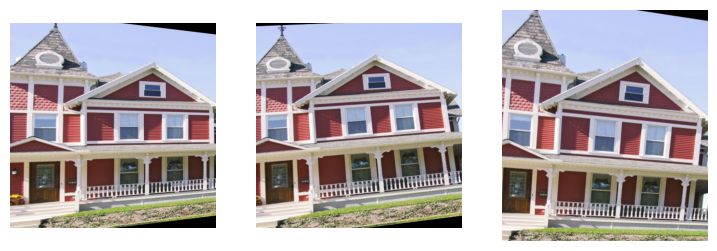

In [140]:
from fastai.vision.all import TensorImage

def _batch_ex(bs):
    return TensorImage(timg[None].expand(bs, *timg.shape).clone())

# plot some sample transformations
y = _batch_ex(9)
for t in tfms: y = t(y, split_idx=0)
_,axs = plt.subplots(1,3, figsize=(9,3))
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax)

# save this image to a file
plt.axis('tight')
plt.savefig('reports/figures/warp.jpg')


In [8]:
# this way was using cap letter as labeler
# dls = ImageDataLoaders.from_name_func(path, files, label_func, bs=5, item_tfms=Resize(224), valid_pct=0.2)
# valid_pct is the percent of images used for validation

# this pulls the label from the file name (stuff before _ or -)
# dls = ImageDataLoaders.from_name_re(path, files, pat='^(.*)[_-].*?.jpg', item_tfms=Resize(224), bs=5)

# trying datablock instead
# here the subfolder name is used as the label
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y = parent_label,
                   splitter = RandomSplitter(valid_pct=0.2, seed=44),
                   item_tfms = Resize(224),
                   batch_tfms = tfms)

# does this help anything?
# batch_tfms = aug_transforms(size=224)
# load the data (batch size 5 minimum)
dls = dblock.dataloaders(path, bs=12)

/Users/chad/github/architecture/env/lib/python3.10/site-packages/torch/_tensor.py:1437: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  ret = func(*args, **kwargs)


NB: this spits out a pytorch warning, but it seems to work still

In [9]:
# show the data
'train:', len(dls.train.items), 'valid:', len(dls.valid.items)

('train:', 52, 'valid:', 13)

In [10]:
print("Training images:\n", [x.stem for x in dls.train.items], "\n")
print("Validation images:\n", [x.stem for x in dls.valid.items])

Training images:
 ['red-victorian-home-wrap-around-porch-964fcce8-6d2ab8ee6f5b4d79941bd8866d1fb9ec', 'detroitbungalow_edited', 'prairie_410NElmwoodAve', '5E39127F-AA2D-456F-BB60-D3AC619AE854', 'StuccoFourSquare', 'bungalow-484149133', '001-1024x680', 'GettyImages-160808926-8259f31f8e924329bf7bc59c0f6e89dc', 'XL_21561_Jones_Listing_201_Market_Street_Bvillle_013', 'Foursquare_1016ElginAve', 'prairie_1624W100thPl', 'main3', 'Foursquare-613SGrove', 'Foursquare_330SLombardAve', 'chicagobungalow4', 'mqa946mcv8m61', '674b8fda13b2840a27e796dc69f82254', '2449FourSquare', 'XL_16916_Front', 'prairie_1712W104thPl', 'GettyImages-165432736-scaled', 'victorian_654NCentralAve', 'main4_prairie-1024x768', '2928FourSquare', 'bungalow_1218Rossell', 'chicagobungalow8', 'Stock-Small-Bungalow-Home-Exterior-AdobeStock_361162520-copy', 'portland-foursquare-home', 'chicagobungalow3', 'stuccobungalow2', 'Foursquare_724SElmwoodAve', '6891-prairie-style-home-chicago', 'americanfoursquare', 'bungalow_932NOakParkAve

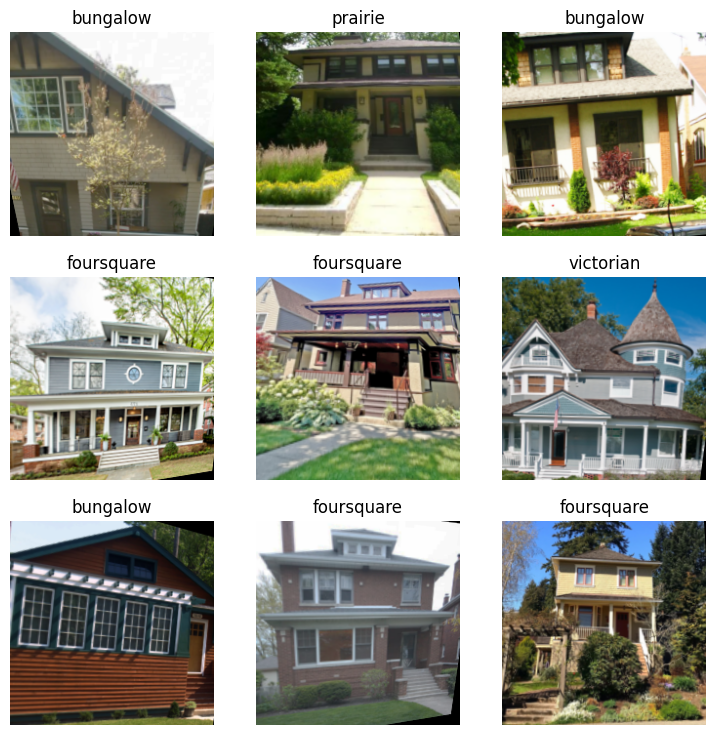

In [11]:
dls.show_batch()

In [12]:
# train the model
learn = vision_learner(dls, resnet34, metrics=error_rate)

# NB this was using ~6 cores on my local machine (macbook)

SuggestedLRs(valley=5.248074739938602e-05)

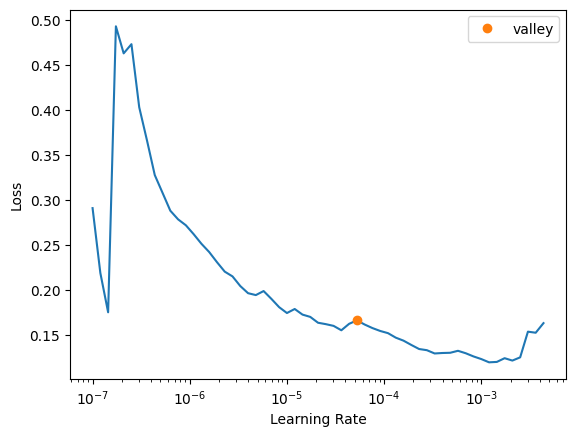

In [126]:
# ?? find optimal parameters for fine-tuning the model
# Find optimal learning rate
learn.lr_find()


In [127]:
# fine tune the learner
learn.fine_tune(15, 5.25e-5)

Getting pretty decent performance (~85% accuracy) with only this very limited image set

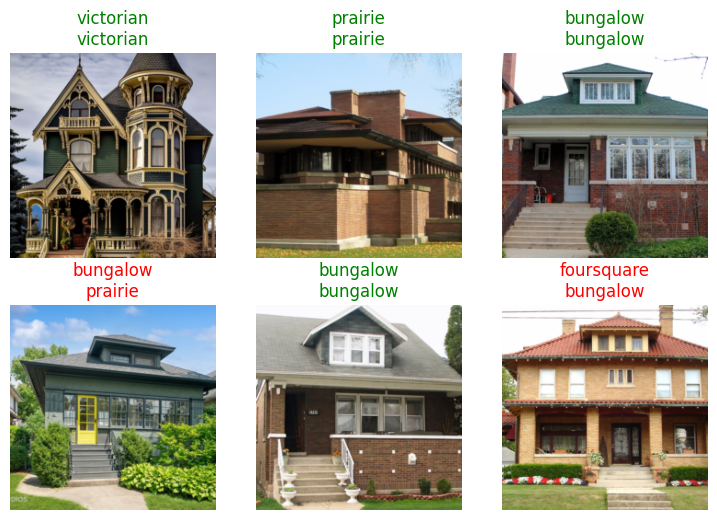

In [129]:
learn.show_results(max_n=6)
plt.savefig('reports/figures/learn_results.png')

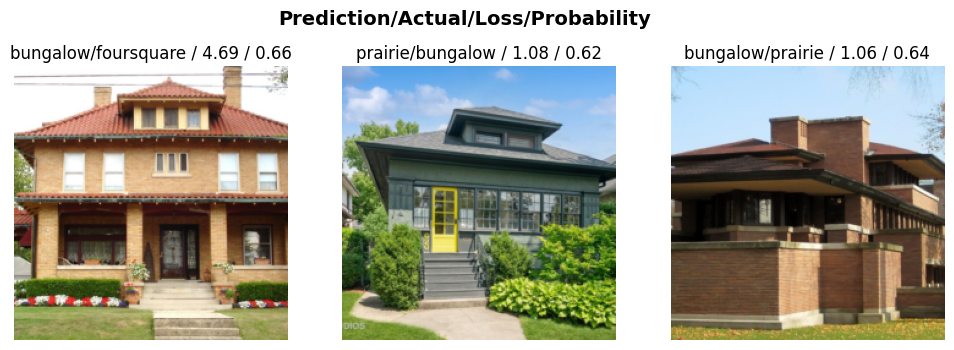

In [15]:
# find the images that give the most problems
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(3, figsize=(12,4))

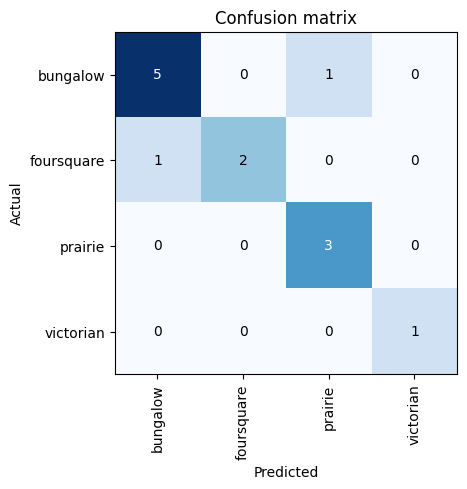

In [141]:
# look at confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
plt.savefig('reports/figures/confusion_matrix.png')

From this, we can see that bungalows, foursquares, and prairie-style homes all kind of blend together.

### Save the model

In [45]:
learn.save('architecture_model')

Path('models/architecture_model.pth')

### Use the model to predict house type from redfin images (takes ~16s for 500 images)

In [17]:
import os
import pandas as pd

learn.load('architecture_model')

# Get list of file paths to the test images
test_images = get_image_files('images/testing')

df_preds = pd.DataFrame(columns=['image', 'prediction', 'probability'])

# Load and predict on each test image
for img_path in test_images:
    img = PILImage.create(img_path)
    pred, _, probs = learn.predict(img)
    # Get the basename of the first test image path
    nm = os.path.basename(img_path)
    # print(f"Image name: {nm}")
    # print(f"Prediction: {pred}, Probability: {probs.max().item()}")
    df = pd.DataFrame({'image': nm, 'prediction': pred, 'probability': probs.max().item()}, index=[0])
    df_preds = pd.concat([df_preds, df])

df_preds['pid'] = df_preds['image'].str.extract(r'pid(\d+)', expand=False)
df_preds.pid = df_preds.pid.astype(int)


/Users/chad/github/architecture/env/lib/python3.10/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=de

/var/folders/68/dksmh04d2l37ttl9pc9k553m0000gp/T/ipykernel_58716/3552729657.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_preds = pd.concat([df_preds, df])


array([[<Axes: title={'center': 'probability'}>]], dtype=object)

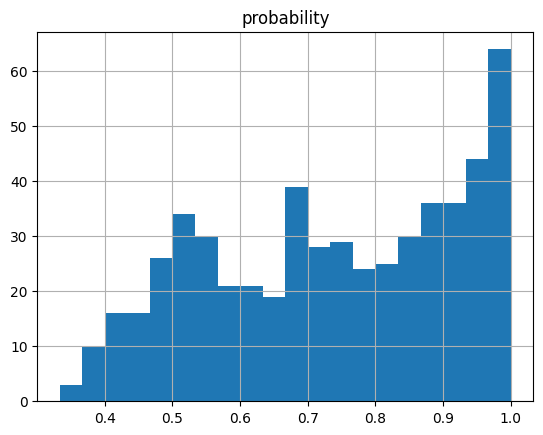

In [18]:
df_preds.hist(column='probability', bins=20)
# df_preds.boxplot(column='probability', by='prediction')


### Create map of architectural diversity by block

<Axes: xlabel='longitude', ylabel='latitude'>

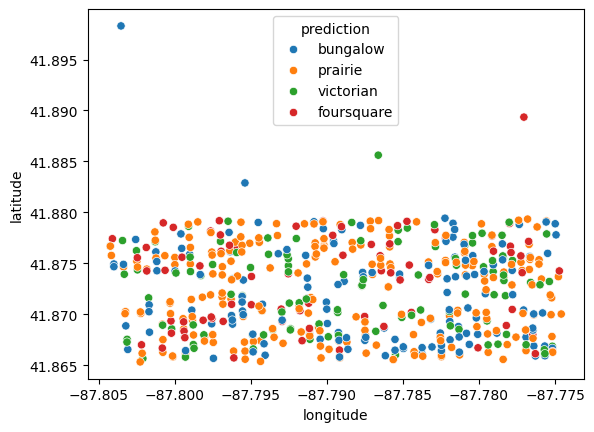

In [19]:
import seaborn as sns

# TODO plot a heatmap of the architectural diveristy by neighborhood

# Extract the relevant part of the image name using regex
# df_preds['extracted'] = df_preds['image'].str.extract(r'(\d+-\w+-\w+-\w+)', expand=False)
# df_preds['extracted'].values[0]

df_merged = df_preds.merge(rf_metadata, left_on='pid', right_on='property_id')

# TODO calculate architecture diversity by neighborhood

# Plot scatter of latitude and longitude with color as prediction
sns.scatterplot(data=df_merged, x='longitude', y='latitude', hue='prediction')

In [20]:
reso = 0.001

latcuts = np.linspace(df_merged['latitude'].min(), df_merged['latitude'].max(), num=int((df_merged['latitude'].max() - df_merged['latitude'].min()) / reso))

loncuts = np.linspace(df_merged['longitude'].min(), df_merged['longitude'].max(), num=int((df_merged['longitude'].max() - df_merged['longitude'].min()) / reso))


In [21]:

# create 2D bins

# Create latitude and longitude bins
df_merged['lat_bin'] = pd.cut(df_merged['latitude'], bins=latcuts)
df_merged['long_bin'] = pd.cut(df_merged['longitude'], bins=loncuts)

# Combine latitude and longitude bins into a single string
df_merged['lat_long_bin'] = df_merged.apply(lambda x: f"{x['lat_bin']}_{x['long_bin']}", axis=1)

# Count the number of predictions in each 2D bin
df_merged['lat_long_bin'].value_counts()

# Calculate the architecture diversity in each 2D bin
diversity = df_merged.groupby('lat_long_bin')['prediction'].nunique().reset_index()
diversity.rename(columns={'prediction': 'diversity'}, inplace=True)

# Now add to the df_merged dataframe
df_merged_div = df_merged.merge(diversity, on='lat_long_bin', how='left')
df_merged_div.head()


image  prediction  probability       pid  \
0  804-S-Scoville-Ave_pid13248076.jpg    bungalow     0.550641  13248076   
1  625-S-Scoville-Ave_pid13249591.jpg     prairie     0.645912  13249591   
2   1127-S-Taylor-Ave_pid13251196.jpg   victorian     0.841857  13251196   
3   800-Gunderson-Ave_pid13248345.jpg  foursquare     0.990721  13248345   
4   631-Gunderson-Ave_pid13249086.jpg  foursquare     0.545966  13249086   

                input               match  property_id   latitude  longitude  \
0  804 S SCOVILLE AVE  804 S Scoville Ave     13248076  41.874120 -87.787644   
1   625 S SCOVILLE AV  625 S Scoville Ave     13249591  41.877056 -87.788332   
2   1127 S TAYLOR AVE   1127 S Taylor Ave     13251196  41.868035 -87.778190   
3   800 GUNDERSON AVE   800 Gunderson Ave     13248345  41.874281 -87.786417   
4    631 GUNDERSON AV   631 Gunderson Ave     13249086  41.876864 -87.787074   

                                            search_url  \
0  /IL/Oak-Park/804-S-Scoville-Ave-60304/home/13248076   
1  /IL/Oak-Park/625-S-Scoville-Ave-60304/home/13249591   
2   /IL/Oak-Park/1127-S-Taylor-Ave-60304/home/13251196   
3   /IL/Oak-Park/800-Gunderson-Ave-60304/home/13248345   
4   /IL/Oak-Park/631-Gunderson-Ave-60304/home/13249086   

                                                                                                                                                                                                                  image_url  \
0                                                                                                                                                 ['https://ssl.cdn-redfin.com/photo/68/mbphoto/797/genMid.12043797_0.jpg']   
1  ['https://maps.googleapis.com/maps/api/streetview?channel=mb-pdp-publicrecord&location=625+S+Scoville+Ave%2C+Oak+Park%2C+IL+60304&size=665x441&source=outdoor&client=gme-redfin&signature=LNysRf6Y4Lup7hlNEXnTjevZ9rU=']   
2                                                                                                                                                 ['https://ssl.cdn-redfin.com/photo/68/mbphoto/139/genMid.10678139_0.jpg']   
3                                                                                                                                                 ['https://ssl.cdn-redfin.com/photo/68/mbphoto/697/genMid.08587697_2.jpg']   
4   ['https://maps.googleapis.com/maps/api/streetview?channel=mb-pdp-publicrecord&location=631+Gunderson+Ave%2C+Oak+Park%2C+IL+60304&size=665x441&source=outdoor&client=gme-redfin&signature=Xl6nVlZ_sP5DaxNw2INi1SlQGTE=']   

   in_oak_park           lat_bin            long_bin  \
0            1  (41.874, 41.875]  (-87.788, -87.787]   
1            1  (41.877, 41.878]  (-87.788, -87.787]   
2            1  (41.867, 41.869]  (-87.779, -87.778]   
3            1  (41.874, 41.875]  (-87.787, -87.786]   
4            1  (41.876, 41.877]  (-87.787, -87.786]   

                          lat_long_bin  diversity  
0  (41.874, 41.875]_(-87.788, -87.787]          1  
1  (41.877, 41.878]_(-87.788, -87.787]          2  
2  (41.867, 41.869]_(-87.779, -87.778]          2  
3  (41.874, 41.875]_(-87.787, -87.786]          3  
4  (41.876, 41.877]_(-87.787, -87.786]          1

In [22]:
# Create a pivot table for the bins
pivot_table_bins = df_merged_div.pivot_table(index='lat_bin', columns='long_bin', values='diversity', aggfunc='mean')

# Set the index and column names to the mid-point of the bin for plotting later
pivot_table_bins.index = pivot_table_bins.index.map(lambda x: x.mid)
pivot_table_bins.columns = pivot_table_bins.columns.map(lambda x: x.mid)

# Display the pivot table
pivot_table_bins


/var/folders/68/dksmh04d2l37ttl9pc9k553m0000gp/T/ipykernel_58716/1942398748.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table_bins = df_merged_div.pivot_table(index='lat_bin', columns='long_bin', values='diversity', aggfunc='mean')


long_bin  -87.8035  -87.8025  -87.8015  -87.8005  -87.7995  -87.7985  \
lat_bin                                                                
41.8655        NaN       1.0       1.0       1.0       2.0       NaN   
41.8665        NaN       3.0       NaN       1.0       1.0       2.0   
41.8680        NaN       1.0       1.0       2.0       1.0       2.0   
41.8695        1.0       NaN       NaN       3.0       2.0       3.0   
41.8705        1.0       1.0       1.0       1.0       NaN       2.0   
41.8715        NaN       NaN       2.0       1.0       NaN       1.0   
41.8725        NaN       NaN       NaN       NaN       NaN       NaN   
41.8735        NaN       NaN       NaN       NaN       NaN       1.0   
41.8745        3.0       2.0       3.0       1.0       3.0       2.0   
41.8755        2.0       2.0       2.0       1.0       4.0       NaN   
41.8765        NaN       1.0       2.0       NaN       2.0       NaN   
41.8775        2.0       1.0       2.0       NaN       2.0       NaN   
41.8785        NaN       NaN       NaN       1.0       2.0       1.0   
41.8795        NaN       NaN       NaN       NaN       NaN       NaN   
41.8825        NaN       NaN       NaN       NaN       NaN       NaN   
41.8865        NaN       NaN       NaN       NaN       NaN       NaN   
41.8895        NaN       NaN       NaN       NaN       NaN       NaN   
41.8975        1.0       NaN       NaN       NaN       NaN       NaN   

long_bin  -87.7975  -87.7965  -87.7955  -87.7945  ...  -87.7845  -87.7835  \
lat_bin                                           ...                       
41.8655        1.0       1.0       2.0       2.0  ...       1.0       2.0   
41.8665        1.0       1.0       2.0       2.0  ...       1.0       1.0   
41.8680        1.0       NaN       2.0       1.0  ...       1.0       NaN   
41.8695        1.0       2.0       NaN       NaN  ...       NaN       2.0   
41.8705        1.0       2.0       2.0       2.0  ...       3.0       2.0   
41.8715        1.0       2.0       2.0       2.0  ...       NaN       NaN   
41.8725        1.0       1.0       2.0       NaN  ...       NaN       NaN   
41.8735        NaN       2.0       2.0       NaN  ...       NaN       1.0   
41.8745        2.0       NaN       1.0       1.0  ...       1.0       2.0   
41.8755        1.0       1.0       NaN       1.0  ...       NaN       1.0   
41.8765        2.0       4.0       1.0       NaN  ...       NaN       NaN   
41.8775        3.0       2.0       1.0       2.0  ...       NaN       NaN   
41.8785        1.0       1.0       1.0       1.0  ...       2.0       1.0   
41.8795        1.0       NaN       NaN       NaN  ...       NaN       NaN   
41.8825        NaN       NaN       1.0       NaN  ...       NaN       NaN   
41.8865        NaN       NaN       NaN       NaN  ...       NaN       NaN   
41.8895        NaN       NaN       NaN       NaN  ...       NaN       NaN   
41.8975        NaN       NaN       NaN       NaN  ...       NaN       NaN   

long_bin  -87.7825  -87.7815  -87.7805  -87.7795  -87.7785  -87.7775  \
lat_bin                                                                
41.8655        1.0       2.0       NaN       1.0       1.0       NaN   
41.8665        2.0       1.0       2.0       1.0       2.0       2.0   
41.8680        2.0       1.0       1.0       1.0       2.0       2.0   
41.8695        NaN       2.0       1.0       2.0       1.0       NaN   
41.8705        NaN       3.0       2.0       1.0       1.0       2.0   
41.8715        NaN       NaN       NaN       NaN       NaN       NaN   
41.8725        1.0       NaN       1.0       3.0       2.0       NaN   
41.8735        1.0       1.0       1.0       1.0       2.0       NaN   
41.8745        2.0       1.0       2.0       3.0       3.0       2.0   
41.8755        1.0       3.0       2.0       1.0       2.0       2.0   
41.8765        1.0       2.0       2.0       2.0       2.0       NaN   
41.8775        3.0       2.0       1.0       3.0       1.0       1.0   
41.8785   

<Figure size 1000x800 with 0 Axes>

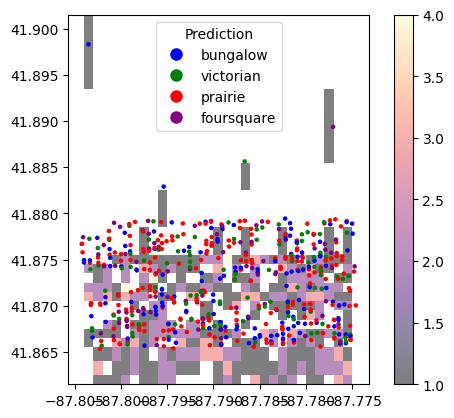

In [23]:
# Heatmap of the architectural diversity by neighborhood

plt.figure(figsize=(10, 8))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pivot_table_bins

c = np.array(df.columns)
x = np.concatenate((c,[c[-1]+np.diff(c)[-1]]))-np.diff(c)[-1]/2.
r = np.array(df.index)
y = np.concatenate((r,[r[-1]+np.diff(r)[-1]]))-np.diff(r)[-1]/2.
X,Y = np.meshgrid(x,y)

fig, ax = plt.subplots(1,1)
pc = ax.pcolormesh(X,Y,df.values, alpha=0.5, cmap="magma")
fig.colorbar(pc)
# ax.scatter(x=5,y=5, s=100)
# Map predictions to categorical color values
prediction_colors = {'bungalow': 'blue', 'victorian': 'green', 'prairie': 'red', 'foursquare': 'purple'}
colors = df_merged_div['prediction'].map(prediction_colors)

# Scatter plot with categorical colors
scatter = ax.scatter(df_merged_div['longitude'], df_merged_div['latitude'], c=colors, s=5)

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
           for label, color in prediction_colors.items()]
ax.legend(handles=handles, title="Prediction")

ax.set_aspect(1)

plt.show()


In [24]:
list(zip(x, y))

[(-87.804, 41.86149999999999),
 (-87.80300000000001, 41.8625),
 (-87.802, 41.86399999999999),
 (-87.801, 41.8655),
 (-87.8, 41.8665),
 (-87.799, 41.86749999999999),
 (-87.798, 41.8685),
 (-87.79700000000001, 41.8695),
 (-87.796, 41.87049999999999),
 (-87.795, 41.8715),
 (-87.794, 41.8725),
 (-87.793, 41.87349999999999),
 (-87.7915, 41.8745),
 (-87.79, 41.8755),
 (-87.789, 41.8785),
 (-87.788, 41.88249999999999),
 (-87.787, 41.88549999999999),
 (-87.786, 41.8935),
 (-87.78500000000001, 41.9015)]

In [30]:
from scipy.interpolate import CloughTocher2DInterpolator
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng()
x = df_merged_div['latitude'].values[0:10]
y = df_merged_div['longitude'].values[0:10]

X = np.linspace(min(x), max(x))
Y = np.linspace(min(y), max(y))

X


# X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation



array([41.8679787 , 41.86817179, 41.86836488, 41.86855796, 41.86875105,
       41.86894414, 41.86913723, 41.86933031, 41.8695234 , 41.86971649,
       41.86990958, 41.87010267, 41.87029575, 41.87048884, 41.87068193,
       41.87087502, 41.8710681 , 41.87126119, 41.87145428, 41.87164737,
       41.87184046, 41.87203354, 41.87222663, 41.87241972, 41.87261281,
       41.87280589, 41.87299898, 41.87319207, 41.87338516, 41.87357824,
       41.87377133, 41.87396442, 41.87415751, 41.8743506 , 41.87454368,
       41.87473677, 41.87492986, 41.87512295, 41.87531603, 41.87550912,
       41.87570221, 41.8758953 , 41.87608839, 41.87628147, 41.87647456,
       41.87666765, 41.87686074, 41.87705382, 41.87724691, 41.87744   ])

In [ ]:


z = np.hypot(x, y) # z function






X = np.linspace(min(x), max(x))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
interp = CloughTocher2DInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)
plt.pcolormesh(X, Y, Z, shading='auto')
plt.plot(x, y, "ok", label="input point")
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()


In [310]:
import pylab as plt
import numpy as np

# Sample data
# side = np.linspace(-2,2,15)

X,Y = np.meshgrid(df_merged_div['longitude'].unique(),df_merged_div['latitude'].unique())
# Z = np.exp(-((X-1)**2+Y**2))

plt.meshgrid(X,Y)

# Plot the density map using nearest-neighbor interpolation
# plt.pcolormesh(X,Y,Z)
# plt.show()

In [37]:
from sklearn.neighbors import NearestNeighbors

# Define the radius (in degrees, approximate for small distances)
radius = 0.002  # Adjust as needed

# Initialize NearestNeighbors with the specified radius
nbrs = NearestNeighbors(radius=radius)

# Fit the model using the latitude and longitude
nbrs.fit(df_merged_div[['latitude', 'longitude']])

# Function to calculate the number of unique predictions within the radius
def count_unique_predictions_within_radius(row):
    # Find neighbors within the radius
    indices = nbrs.radius_neighbors([row[['latitude', 'longitude']]], return_distance=False)[0]
    # Get the unique predictions
    unique_predictions = df_merged_div.iloc[indices]['prediction'].unique()
    return len(unique_predictions)

# Apply the function to each row
df_merged_div['unique_predictions_in_radius'] = df_merged_div.apply(count_unique_predictions_within_radius, axis=1)


/Users/chad/github/architecture/env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/chad/github/architecture/env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/chad/github/architecture/env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/chad/github/architecture/env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/chad/github/architecture/env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature nam

In [55]:
# Load roads

import geopandas as gpd

# Import all roads NL
map_df = gpd.read_file('data/raw/roads/Street_Centerlines.shp')

# Show data format
# Convert to latitude and longitude
map_df = map_df.to_crs(epsg=4326)
map_df.head()



TYPE  SPEEDLIMIT                                GlobalID   SHAPE_Leng  \
0     1          65  {3910C005-FFFE-4B3E-95B4-A38305AD9DE6}  1338.737406   
1     1          65  {EC444AB6-8D39-4DA3-A6AA-A161895246B1}  1104.805792   
2     1          65  {905B2A0C-7FCD-4D74-B23D-98F0BCB48AF1}  1072.906512   
3     1          65  {2E8AA4BC-42B9-48B6-96D9-4C5893AAE6A5}   103.077524   
4     1          65  {C02D382B-189B-4349-B2B4-0E6642439D63}   195.124919   

    STREETNAME                              GlobalID_1  \
0    I290 EXPY  {E52968BC-4A94-4CBF-B9AB-9931E4686C9F}   
1  I290 RAMP W  {EF95E3ED-97F5-4742-84A4-6D0C7644138C}   
2    I290 EXPY  {E52968BC-4A94-4CBF-B9AB-9931E4686C9F}   
3    I290 EXPY  {E52968BC-4A94-4CBF-B9AB-9931E4686C9F}   
4    I290 EXPY  {E52968BC-4A94-4CBF-B9AB-9931E4686C9F}   

                                                                                                                                                  geometry  
0                                                                                  LINESTRING (-87.78906 41.87218, -87.78567 41.87189, -87.78418 41.87175)  
1  LINESTRING (-87.77814 41.87129, -87.77795 41.87108, -87.77768 41.87099, -87.77751 41.87095, -87.77724 41.87092, -87.77443 41.87075, -87.77429 41.87075)  
2                       LINESTRING (-87.77814 41.87129, -87.77791 41.87128, -87.77646 41.8712, -87.77491 41.87108, -87.77445 41.87104, -87.77422 41.87102)  
3                                                                                                      LINESTRING (-87.77852 41.87132, -87.77814 41.87129)  
4                                                                                                      LINESTRING (-87.77923 41.87136, -87.77852 41.87132)

In [58]:
from scipy.interpolate import griddata
import numpy as np

import matplotlib.pyplot as plt

# Assuming x, y, and z are already defined
x = df_merged_div['longitude'].values
y = df_merged_div['latitude'].values
z = df_merged_div['unique_predictions_in_radius'].values
# z = np.hypot(x, y)  # Example z values, replace with actual data

# Define grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# Interpolate using griddata
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')


In [124]:
df_merged_div['prediction'].value_counts()

# df_merged_div.probability.groupby(df_merged_div['prediction']).max()



prediction
prairie       227
bungalow      139
victorian     107
foursquare     80
Name: count, dtype: int64

In [106]:

fig, ax = plt.subplots(1, figsize=(10,14))

# Plot the interpolated data
plt.imshow(grid_z.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='bone')

# Add a color bar
cbar = plt.colorbar(label='Number of unique homes in a 0.001º radius', shrink=0.5)

# Map predictions to categorical color values
prediction_colors = {'bungalow': '#003f5c', 'victorian': '#7a5195', 'prairie': '#ef5675', 'foursquare': '#ffa600'}
colors = df_merged_div['prediction'].map(prediction_colors)

# Add roads
map_df.plot(ax=ax, color='w', linewidth=0.5)

# Scatter plot with categorical colors of predicted home types
plt.scatter(x, y, c=colors, edgecolors='k', linewidths=0.5)
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Set the title
plt.title('Architecture Diversity in Oak Park, IL')

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
           for label, color in prediction_colors.items()]
plt.legend(handles=handles, title="House type")

# Turn off the axis
plt.axis('off')

plt.ylim(min(y), max(y))

# Save the plot
plt.savefig('reports/figures/architecture_diversity.png', dpi=300, bbox_inches='tight')



